## Download the pre trained Vgg16 model from keras

In [1]:
import os, sys
import glob
import shutil
import zipfile
import numpy as np
from numpy.random import random, permutation
from keras import applications
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop, Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt
import time

Using TensorFlow backend.


In [2]:
vgg_model = applications.VGG16(weights='imagenet', include_top=True)

In [3]:
!sudo find / -iname 'vgg16_weights_tf_dim_ordering_tf_kernels.h5' -print

/home/ubuntu/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels.h5


## Download data from Kaggle
1. Get a login and pwd with Kaggle
2. Go to the competition and accept the rules (This is a must)
3. Install the Kaggle-cli (as below). It is quite useful

## Data management
1. Make the following directories a. train b. valid c. test d. sample/train e. sample/valid
2. Unzip the train data into train
3. Move 10% of train data into valid
4. copy 100 data items into sample/train - this and 5 is for testing out the code locally
5. copy 50 data items into sample/valid

A small sample data set of less than 100 train and maybe 50 valid data points is very useful to test out your code

In [3]:
%matplotlib inline

In [4]:
data_path = "/home/ubuntu/nbs/data/kaggle_dogscats/"
if not os.path.exists(data_path):
    os.mkdir(data_path)
    os.chdir(data_path)
    print(os.getcwd())
    !kg download -u 'xxxxxxx' -p 'xxxxxxx' -c 'dogs-vs-cats-redux-kernels-edition' 
    #with os.scandir(data_path) as files:
    for file in os.scandir(data_path):
        if file.name.endswith('.zip'):
            print(os.stat(data_path + file.name).st_size, file.name)
            with zipfile.ZipFile(file.name, 'r') as z:
                z.extractall(data_path)
print(os.stat(data_path).st_size)
#with os.scandir(data_path) as files:
for file in os.scandir(data_path):
    print(file.name)
os.chdir(data_path + 'train')
print('Train data sample')
!ls | head -n 5
!ls | tail -n 5
os.chdir(data_path + 'test')
print('Test data sample')
!ls | head -n 5
!ls | tail -n 5
os.chdir(data_path)

4096
train
valid
test
sample_submission.csv
train.zip
models
test.zip
sample
Train data sample
cats
dogs
cats
dogs
Test data sample
unknown
unknown


In [5]:
if not os.path.exists(data_path + 'train' + '/cats'):
    !mkdir train/cats    
    !mv train/cat.*.jpg train/cats/
    os.chdir(data_path + 'train' + '/cats')
    print('number of cats')
    !ls | wc -l
os.chdir(data_path)
if not os.path.exists(data_path + 'train' + '/dogs'):   
    !mkdir train/dogs
    !mv train/dog.*.jpg train/dogs/
    os.chdir(data_path + 'train' + '/dogs')
    print('number of dogs')
    !ls | wc -l
os.chdir(data_path)

In [6]:
def create_validation_data(in_dir, out_dir, valid_percent):

    valid_size = int(len([name for name in os.listdir(in_dir)]) * valid_percent)
    os.chdir(in_dir)
    g = glob.glob('*.jpg')
    shuffled = np.random.permutation(g)
    if not int(len([name for name in os.listdir(out_dir)])):
        for i in range(valid_size): 
            shutil.move(shuffled[i], out_dir + shuffled[i])
    valid_data_size = len([name for name in os.listdir(out_dir)])
    print(valid_data_size, out_dir)

In [7]:
if not os.path.exists(data_path + 'valid'):
    os.makedirs('valid/cats')
    os.makedirs('valid/dogs')
    create_validation_data((data_path + 'train' + '/dogs'), (data_path + 'valid' + '/dogs/'), 0.1)
    create_validation_data((data_path + 'train' + '/cats'), (data_path + 'valid' + '/cats/'), 0.1)

### create the sample data set with its own train, valid and test folders

In [8]:
def create_samples(source, dest, sample_size, sam_type):
    if not os.path.exists(dest):
        os.makedirs(dest)
        os.chdir(source)
        g = glob.glob('*.jpg')
        shuffled = np.random.permutation(g)
        if sam_type == 'valid':
            sample_size = int(sample_size * .5)
        for i in range(sample_size):
            shutil.copyfile(shuffled[i], dest + shuffled[i])
        print(dest, len([name for name in os.listdir(dest)]))

create_samples((data_path + 'train/dogs'), (data_path + 'sample/train/dogs/'), 40, 'train')
create_samples((data_path + 'train/cats'), (data_path + 'sample/train/cats/'), 40, 'train')
create_samples((data_path + 'valid/dogs'), (data_path + 'sample/valid/dogs/'), 40, 'valid')
create_samples((data_path + 'valid/cats'), (data_path + 'sample/valid/cats/'), 40, 'valid')
        

In [9]:
#path = data_path + 'sample/'
path = data_path
model_path = path + 'models/'
if not os.path.exists(model_path): 
    os.mkdir(model_path)

## Model workflow
1. Create a process for batch generation from training and validation data
2. Check the data shape of inputs and labels and make changes, if necessary

In [10]:
batch_size=100
#batch_size=10
#batch_size=50

## Some useful keras tools
Keras provides some useful image pre processing tools
1. ImageDataGenerator() - does real time augmentation of the image and produces an image of a target size. This is necessary when the input images may not be of same size
2. flow_from_directory method in ImageDataGenerator() creates batches (default batch_size=32) of data provided the data is stored in sub directories which will be presumed to be each of a class.

## Data preprocessing
1. Image augmentation (all images need to be of the same size)
2. Creating bacthes of data

In [12]:
#we are using the default values of ImageDataGenerator. If the number of images are few, then additional images can be
#created in the folders using data augmentation as illustrated in the following cells

def classes_from_dir(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=batch_size, class_mode='binary',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [13]:
val_batch_class = classes_from_dir(path+'valid', shuffle=False, batch_size=batch_size)
trn_batch_class = classes_from_dir(path+'train', shuffle=False, batch_size=batch_size)

Found 2500 images belonging to 2 classes.
Found 22500 images belonging to 2 classes.


In [14]:
def get_data(path, batch_size, target_size=(224,224)):
    #batches = image.ImageDataGenerator().flow_from_directory(path, target_size=target_size,
            #class_mode=None, shuffle=False, batch_size=batch_size)
    batch_class = classes_from_dir(path, shuffle=False, batch_size=batch_size, class_mode=None, target_size=target_size)
    return np.concatenate([batch_class.next() for i in range(int(batch_class.samples/batch_size))])

In [15]:
val_data = get_data(path+'valid', batch_size)
trn_data = get_data(path+'train', batch_size)

Found 2500 images belonging to 2 classes.
Found 22500 images belonging to 2 classes.


In [16]:
trn_data.shape

(22500, 224, 224, 3)

In [17]:
val_data.shape

(2500, 224, 224, 3)

In [18]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [19]:
val_classes = val_batch_class.classes
trn_classes = trn_batch_class.classes
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)

In [20]:
trn_labels.shape

(22500, 2)

In [21]:
trn_classes[:2]

array([0, 0], dtype=int32)

In [22]:
trn_labels[:2]

array([[1., 0.],
       [1., 0.]])

In [23]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [24]:
vgg_model.layers.pop()
for layer in vgg_model.layers: layer.trainable=False
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
from keras.models import Model
new_layer = Dense(2, activation='softmax', name='predictions')
inp = vgg_model.input
out = new_layer(vgg_model.layers[-1].output)
model2 = Model(inp, out)

In [26]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
batches = image.ImageDataGenerator().flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
val_batches = image.ImageDataGenerator().flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

In [28]:
def fit_model(model, batches, val_batches, batch_size, nb_epoch=1):
    model.fit_generator(batches, steps_per_epoch=batches.n/batch_size, epochs=nb_epoch, 
                        validation_data=val_batches, validation_steps=val_batches.n/batch_size)

In [29]:
print(batches.n)

22500


In [30]:
#opt = RMSprop(lr=0.1)
model2.save_weights(model_path+'run_test4-bat100-epoch-'+'init'+'-'+'vgg16.h5')
opt = Adam(lr=0.001, decay=1e-06)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

### saving the model weights periodically will let you revert easily to a better model if overfitting occurs

In [31]:
num_of_epochs = 1
for i in range(num_of_epochs):
    start = time.time()
    fit_model(model2, batches, val_batches, batch_size, nb_epoch=1)
    model2.save_weights(model_path+'run_test4-bat100-epoch-'+str(i+1)+'-'+'vgg16.h5')
    end = time.time()
    print(end - start)

Epoch 1/1
225/225 [==============================] - 274s 1s/step - loss: 0.1181 - acc: 0.9581 - val_loss: 0.0973 - val_acc: 0.9644
274.65870094299316


## Load weights from last saved weights

In [34]:
model2.load_weights(model_path+'run_test4-bat100-epoch-'+str(1)+'-'+'vgg16.h5')
opt = Adam(lr=0.001, decay=1e-06)
model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
num_of_epochs = 1
for i in range(num_of_epochs):
    start = time.time()
    fit_model(model2, batches, val_batches, batch_size, nb_epoch=1)
    model2.save_weights(model_path+'run_test4-bat100-epoch-'+str(i+2)+'-'+'vgg16.h5')
    end = time.time()
    print(end - start)

Epoch 1/1
225/225 [==============================] - 267s 1s/step - loss: 0.0833 - acc: 0.9715 - val_loss: 0.0915 - val_acc: 0.9712
268.13546085357666


In [36]:
!cat ../../data/kaggle_dogscats/sample_submission.csv | head -n 5

id,label
1,0.5
2,0.5
3,0.5
4,0.5
cat: write error: Broken pipe


## Inspect results on validation data

In [37]:

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


In [38]:
def plots_idx(idx, titles=None):
    plots([image.load_img(path + 'valid/' + filenames[i]) for i in idx], titles=titles)

In [39]:
# We want both the classes...
probs = model2.predict(val_data, batch_size=batch_size)
probs = np.round(probs, 5)
probs[:, 0]
preds = probs.argmax(axis=-1)
preds[:4]

array([0, 0, 0, 0])

In [40]:
filenames = val_batch_class.filenames

In [41]:
# Number of images to view for each visualization task
n_view = 4

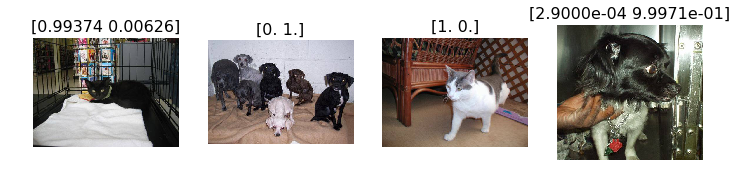

In [42]:
#1. A few correct labels at random

correct = np.where(preds==val_labels[:,1])[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

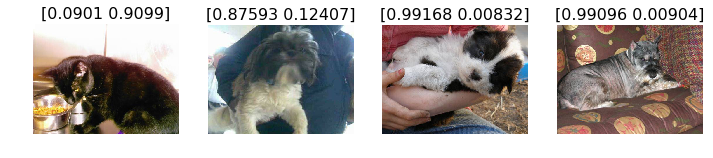

In [43]:
#2. A few incorrect labels at random

incorrect = np.where(preds!=val_labels[:,1])[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

## Confusion matrix is a good way to visualize the quality of classification 

In [44]:
cm = confusion_matrix(val_classes, preds)

In [45]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


[[1227   23]
 [  49 1201]]


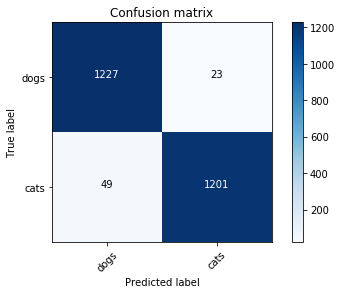

In [46]:
plot_confusion_matrix(cm, val_batch_class.class_indices)

### for testing the images have to be put into a sub directory

In [47]:
test_path = path+'test/'
print(test_path)
if not os.path.exists(test_path):
    os.mkdir(test_path)

/home/ubuntu/nbs/data/kaggle_dogscats/test/


In [48]:
#need to have folder for the test data for the classes in this case unknown because we are using flow_from_directory
#in our function classes_from_dir which we use later for test images

if not os.path.exists(test_path+'unknown/'):
    os.mkdir(test_path+'unknown/')  
    in_dir = os.listdir(test_path)
    os.chdir(path+'test')
    g = glob.glob('*.jpg')
    shuffle = np.random.permutation(g)
    for file in in_dir:

        shutil.move(file, test_path+'unknown/')
path, dirs, files = os.walk(test_path+'unknown/').__next__()
print(len(files))

12500


## Some inspection of the predictions on test data

In [49]:
test_image_path = test_path
def test_plots_idx(idx, path, titles=None):
    plots([image.load_img(path + test_batches.filenames[i]) for i in idx], titles=titles)

In [50]:
def test_gen(path, batch_size):
    test_batches = classes_from_dir(path, shuffle=False, batch_size=batch_size, class_mode='binary')
    return test_batches, model2.predict_generator(test_batches, test_batches.n/batch_size)

In [51]:
test_batch_size = 100
test_batches, preds = test_gen(test_path, test_batch_size)

Found 12500 images belonging to 1 classes.


In [52]:
print(len(np.rint(preds[:,1])))

12500


In [53]:
test_batches.filenames[:5]

['unknown/1.jpg',
 'unknown/10.jpg',
 'unknown/100.jpg',
 'unknown/1000.jpg',
 'unknown/10000.jpg']

In [54]:
#is_cat = np.where(np.rint(preds[:,0])==1)
is_dog = np.where(np.rint(preds[:,1])==1)
idx = np.squeeze(is_dog)
print(len(idx))
idx = idx[5007:5011]
print(idx)

6121
[10205 10206 10207 10209]


In [55]:
print(preds[:,0])

[2.4695988e-03 1.0000000e+00 9.9998128e-01 ... 1.8826092e-06 1.0000000e+00
 9.9983025e-01]


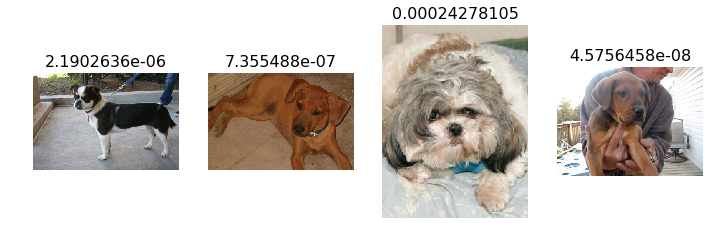

In [56]:
test_plots_idx(idx, test_image_path, preds[:,0][idx])

In [57]:
ids = [int(f[8:f.find('.')]) for f in test_batches.filenames]
print(len(ids))

12500


In [ ]:
is_dog = preds[:,1]
# an useful trick, if the eval criteria is log-loss, because 0 or 1 predictions, 
#or over confident predictions are penalized
# if accuracy was the eval criteria, then 1 and 0's are expected and the predictions should be accordingly converted
is_dog = np.squeeze(is_dog)
is_dog = np.clip(is_dog, 0.03, 0.97) 
print(len(is_dog))
print(is_dog[:5])

## Preparing data for submission to Kaggle

In [ ]:
subm = np.stack([ids, is_dog], axis=1)
print(subm[:5])

In [ ]:
np.savetxt(data_path+'clip_bat100_subm003.csv', subm, fmt='%d,%.5f', header='id, label', comments='')

In [ ]:
import os
data_path = "/home/ubuntu/nbs/data/kaggle_dogscats/"
os.chdir(data_path)
print(os.getcwd())

In [ ]:
!kg submit 'clip_bat100_subm003.csv' -c 'dogs-vs-cats-redux-kernels-edition' -u 'xxxxxx' -p 'xxxxxxxx' -m ""

In [ ]:
!cat ../clip_bat100_subm003.csv | head -n 5